# 2D Shallow Water Equations 🌊

This notebook is a Devito reimplementation from this
[notebook](https://github.com/daniel-koehn/Differential-equations-earth-system/blob/e291791b6d6b32f776af01532b37a9869c5cf569/10_Shallow_Water_Equation_2D/01_2D_Shallow_Water_Equations.ipynb).
We will use an approximation to the Navier-Stokes equations - the 2D
Shallow Water equations - in order to model the propagation of Tsunami
events.

I’ve only made minor modifications to the text, in order to make it more
compatible to the new coding format.

Author: Átila Saraiva Q. Soares.

## Governing Equations

Starting from the continuity and momentum conservation equations, we
want to model the following problem:

<img src="images/shallow_water_sketch.png" style="width: 800px;"/>

For a given bathymetry model, which can include a complex seafloor
topography, we want to model the amplitudes, speed and interaction of
waves at the seasurface. At a given point $(x,\; y)$, the thickness of
the water column between the seafloor and undisturbed water surface is
defined by the variable $h$, while the wave amplitude is $\eta$ and
therefore the whole thickness of the water column $D = h + \eta$.

Using appropriate boundary conditions at the water surface/seafloor,
assuming that the horizontal wavelength of the modelled waves are much
larger than the water depth and integrating the conservation of mass and
momentum equations over the water column, we can derive the following
equations to decribe wave propagation

known as **2D Shallow Water Equations (SWE)**. The derivation of these
equations is beyond the scope of this notebook. Therefore, I refer to
the [Tsunami Modelling
Handbook](http://www.tsunami.civil.tohoku.ac.jp/hokusai3/J/projects/manual-ver-3.1.pdf)
and the lecture [Shallow Water Derivation and Applications by Christian
Kühbacher](http://www.mathematik.tu-dortmund.de/lsiii/cms/papers/Kuehbacher2009.pdf)
for further details.

In Eq. (1) the discharge fluxes $M,\; N$ in x- and y-direction,
respectively are given by

with the horizontal velocity components $u,\;v$ in x- and y-direction,
while $g$ denotes the gravity acceleration. The terms
$\frac{g \alpha^2}{D^{7/3}} M \sqrt{M^2+N^2}$ and
$\frac{g \alpha^2}{D^{7/3}} N \sqrt{M^2+N^2}$ describe the influence of
seafloor friction on the wave amplitude. $\alpha$ denotes the Manning’s
roughness which can be as small as 0.01 for neat cement or smooth metal
up to 0.06 for very poor natural channels (see [Tsunami modelling
handbook](http://www.tsunami.civil.tohoku.ac.jp/hokusai3/J/projects/manual-ver-3.1.pdf)).

The Shallow Water Equations can be applied to

-   Tsunami prediction
-   Atmospheric flow
-   Storm surges
-   Flows around structures
-   Planetary flows

and easily extended to incorporate the effects of Coriolis forces, tides
or wind stress.

## Operator implementation

This is a simple function which returns the operator that solves this
equation. The important part is the operator, which contains all the
equations expressed above.

In [1]:
from devito import Eq, TimeFunction, sqrt, Function, Operator, Grid, solve, ConditionalDimension
from matplotlib import pyplot as plt
import numpy as np


def ForwardOperator(etasave, eta, M, N, h, D, g, alpha, grid):
    """
    Operator that solves the equations expressed above.
    It computes and returns the discharge fluxes M, N and wave height eta from
    the 2D Shallow water equation using the FTCS finite difference method.
    
    Parameters
    ----------
    eta : TimeFunction
        The wave height field as a 2D array of floats.
    M : TimeFunction
        The discharge flux field in x-direction as a 2D array of floats.
    N : TimeFunction
        The discharge flux field in y-direction as a 2D array of floats.
    h : Function
        Bathymetry model as a 2D array of floats.
    D : Function
        Total thickness of the water column.
    g : float
        gravity acceleration.
    alpha : float
        Manning's roughness coefficient.
    etasave : TimeFunction
        Function that is sampled in a different interval than the normal propagation
        and is responsible for saving the snapshots required for the following
        animations.
    """
    
    eps = np.finfo(grid.dtype).eps
    
    # Friction term expresses the loss of amplitude from the friction with the seafloor
    frictionTerm = g * alpha**2 * sqrt(M**2 + N**2) / D**(7./3.)

    # System of equations
    pde_eta = Eq(eta.dt + M.dxc + N.dyc)
    pde_M   = Eq(M.dt + (M**2/D).dxc + (M*N/D).dyc + g*D*eta.forward.dxc + frictionTerm*M)
    pde_N   = Eq(N.dt + (M.forward*N/D).dxc + (N**2/D).dyc + g*D*eta.forward.dyc + g * alpha**2 * sqrt(M.forward**2 + N**2) / D**(7./3.)*N)

    stencil_eta = solve(pde_eta, eta.forward)
    stencil_M   = solve(pde_M, M.forward)
    stencil_N   = solve(pde_N, N.forward)

    # Equations with the forward in time term isolated
    update_eta  = Eq(eta.forward, stencil_eta, subdomain=grid.interior)
    update_M    = Eq(M.forward, stencil_M, subdomain=grid.interior)
    update_N    = Eq(N.forward, stencil_N, subdomain=grid.interior)
    eq_D        = Eq(D, eta.forward + h)

    return Operator([update_eta, update_M, update_N, eq_D] + [Eq(etasave, eta)])

The following function transforms the saved wavefield snapshots and
transform them into a video compatible with jupyter notebook.

In [2]:
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import matplotlib.animation as animation


def snaps2video (eta, title):
    fig, ax = plt.subplots()
    matrice = ax.imshow(eta.data[0, :, :].T, vmin=-1, vmax=1, cmap="seismic")
    plt.colorbar(matrice)

    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(title)    

    def update(i):
        matrice.set_array(eta.data[i, :, :].T)
        return matrice,

    # Animation
    ani = animation.FuncAnimation(fig, update, frames=nsnaps, interval=50, blit=True)

    plt.close(ani._fig)
    display(HTML(ani.to_html5_video()))

In [3]:
def plotDepthProfile (h, title):
    fig, ax = plt.subplots()
    matrice = ax.imshow(h0)
    plt.colorbar(matrice)
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title(title)
    plt.show()

## Example I: Tsunami in ocean with constant depth

After writing the `Shallow_water_2D` code and all the required functions
attached to it, we can define and run our first 2D Tsunami modelling
run.

Let’s assume that the ocean model is \$ L_x = 100; m\$ in x-direction
and $L_y = 100\; m$ in y-direction. The model is discretized with
$nx=401$ gridpoints in x-direction and $ny=401$ gridpoints in
y-direction, respectively.

In this first modelling run, we assume a constant bathymetry $h=50\;m$.
The initial wave height field $\eta_0$ is defined as a Gaussian at the
center of the model, with a half-width of 10 m and an amplitude of 0.5
m. Regarding the initial discharge fluxes, we assume that

In order to avoid the occurence of high frequency artifacts, when waves
are interacting with the boundaries, boundary conditions will be
avoided. Normally Dirichlet conditions are used for the M and N
discharge fluxes, and Neumann for the wave height field. Those lead to
significant boundary reflections which might be not realistic for a
given problem.

Let’s assume the gravity $g = 9.81$ and the Manning’s roughness
coefficient $\alpha = 0.025$ for the all the remaining examples.

In [4]:
Lx    = 100.0   # width of the mantle in the x direction []
Ly    = 100.0   # thickness of the mantle in the y direction []
nx    = 401     # number of points in the x direction
ny    = 401     # number of points in the y direction
dx    = Lx / (nx - 1)  # grid spacing in the x direction []
dy    = Ly / (ny - 1)  # grid spacing in the y direction []
g     = 9.81  # gravity acceleration [m/s^2]
alpha = 0.025 # friction coefficient for natural channels in good condition

# Maximum wave propagation time [s]
Tmax  = 3.
dt    = 1/4500.
nt    = (int)(Tmax/dt)
print(dt, nt)

x = np.linspace(0.0, Lx, num=nx)
y = np.linspace(0.0, Ly, num=ny)

# Define initial eta, M, N
X, Y = np.meshgrid(x,y) # coordinates X,Y required to define eta, h, M, N

# Define constant ocean depth profile h = 50 m
h0 = 50. * np.ones_like(X)

# Define initial eta Gaussian distribution [m]
eta0 = 0.5 * np.exp(-((X-50)**2/10)-((Y-50)**2/10))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + 50.

grid  = Grid(shape=(ny, nx), extent=(Ly, Lx), dtype=np.float32)

0.00022222222222222223 13500

In [5]:
# NBVAL_IGNORE_OUTPUT

nsnaps = 400

# Defining symbolic functions
eta   = TimeFunction(name='eta', grid=grid, space_order=2)
M     = TimeFunction(name='M', grid=grid, space_order=2)
N     = TimeFunction(name='N', grid=grid, space_order=2)
h     = Function(name='h', grid=grid)
D     = Function(name='D', grid=grid)

# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)


# Compile the operator
op = ForwardOperator(etasave, eta, M, N, h, D, g, alpha, grid)

# Use the operator
op.apply(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

The nt/nsnaps factor is 34

Operator `Kernel` ran in 17.97 s

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=17.90456999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.061892000000000044, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [6]:
# NBVAL_SKIP
snaps2video(etasave, "Modeling a tsunami in ocean with constant depth")

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABIxptZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz05IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAGtdliIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAACurHPsRPNnqbElqAErX14M9rch2wv223VNYLTNC0fwxzx/
u/29jz6tfQbFkM2SEBE44cm9Y086xF4IJ6I30xfB/1R3xo/0gY6oNLSQjDRTuoQz2zUAbm+VlY+b
R7BJF+s89k9Dues4P4Yvy9FCe2nH+m0CzevZCSkQ3zu6SAxhKG/cgBI2QYnak9VEW51aOTILh5Y3
k0kEDAdku5WY/zoks0h6BU6wT3qxkGv50Gx+Qzc+9jPQFGFcMghfMQ8JXa8NjCbjvP/QpJG+gp+B
ukzbQCXF7e2TZ/bjPE8NSJ06B/6pC5fGqPS8SQfJrhlm7clNJng91AoON1WUAXo21/Ox3v6RkXrw
uS19G9QX17N75cESAwQHmD8dEX8owD/tBrDXDX4rQOz+AxJycLDNQMvXeARRswrPGcbJNJ5ixtw2
x/K75J6c/2X9UEySzhecDqshl8XPCOtaknYmpyjm8eB05Y2/tDhaNvhXCFGweBC9K8V2n6vYa48A
Ha367VHUctQKOnMUmJ8/Kjil2/A+P/vVKe+fKiDheozlD1+SP5zXahhRKYhpZGqQSpZlaUqHwTje
H435dKZkdkbrnglFJqj+sd/UhzHY/vwdzVSzrYALzUGzLneg0/gXj5HR7mctr7CdaF9GlQj4HkyT
yNs8BVDTqBgNfql556RxDEf9HhH+Gkb7i+zEfyaBBtKRQaFQ8672ycgfWd5b2918w3CrkwmPK1jv
lCturzDO6UJig919vekYSN+Oj5/Noo26L6Gkt/lIYOyVgdIFUaqdufKqwAiJV0MPsEZtzYlHNJbT
itde9RDwQDBl9Fjzj9vqM94Hf9qNXHrlvh6qeUsej4z447rg7SCuiQEpDHZrci74YoQE6aEbovHq
QzQaJZSk56tLPiX1qKkCgHb+9/bVFZRGS8qRC42lw37iwAWCPBf2ubxrXZnwrvSTZtoezAHq5zyI
eNn398Gzbiv4Fv5cc13lXqH/eWcoLf2GvgtuVinhQWPw/D74dM9N1vE7U4mA6qCx9rMlrym2+thh
0h94gSi0NpMEtXgOJ6hFoTb2bGySZXaPhgOWLFxnc/DLkxrl5eUru6rw+AALlRLxbsJlBhAchwki
2FR6IHhSu+BpCXC6NneTT2DxSRGAFDNQcncFzZMx6Sb9gl/0wl7XEm9U+ur4wDX6q3KJn7dvpEca
uTaJaaEW1epncoLI7SG+r8Ejz+/+ZtYhD6/+h90RAA6TV1A3k2TxhNee5N8/DE5JOU9IHZNUW5NH
BLGieB36ogLC7mFaISYtwV3u3fzswjqH8qgLfSVEZiuvUVKDYYwd/C8H1gzX96Q/I+PNcFVgHHQV
MbUjRytOH8zRI8D36/befBomWmBj9KHGRdI07YVtkGqPUdAynXSMa92hUxbbwjEaxd783jypS7K+
uTpe609wm7mfhKMeaVpuBunFy+ZiHMux4j0949T7QHciTZFbXMNuNR7IS9VJmUKhsIPuvSKnuxMl
ezdCZIilOj2rfXG9nyoCN/b1g6IsHnqmqGAkLR4Gu1vTb+gBnqK+opBN23knA6mKRuZjZakfNCSZ
bvmkUWvFpUxouZ9O59E3YzAp/BDRLMNibqa4TDhOtCaeoBEZn+J2O7MM6ilf32v6YHa88KDDPFWB
ta+kQ5bVBUikChHSO8QLfYSOh0MIiRdsojC57UWov5oB8nKwAyepB/qNNJW224o+3ydcsIyx6f1V
nYKj8m7zkI33UkhxqayZ8rK/uRDifsCQ7FqkDKx/TWN90yYEdQX8qFUThO4Zgenl5z1mq+QA97/V
N0cCb3aX5cgNyJIrEXo6O7iEU5WE3K38TYr1K4D3pkOZX2cJuLto0INS2OEfw3GXLnRESU30gyqa
z3PRX/JVUTlUBUsQOrbgHIf7C7fI871AkS1Ax0CShzBWmELe0214ZwqLh/5JEJKL6AI+bYhWMAIm
uDnsxSpkUIVvEC0XMteYM8ZvD4SjQAlBoTzv2yuvx8bnnD7SaHbOcljnGj+jkuV7N4zcZ8hrqYgY
/HK3MPlz/L30drv62gZc2cc71k38z3cdjlstPMrp958IgH+mCu3IMfPxH7fxQja5KvAu4u5PnNAg
IQolclXm9zBr4k7zq1OY/FgymdRJC49/UlMH1bqCgkRP39sM+JSFHsTrrzfudE4QsXtGiBSXrZS7
41a+aTD2DpBsK/dZrBceNmO5stisMZVB8iAJ+WAVkJ/1fhh/q9CUbwhN0XhmW53luVEDnIoef6mm
pf7koh2jnDtdCZ8z04WQgm/qcfaWWWzYtKAmpJMsq6FCks00Au20L5MRMKrFx2d6zxCIXAGQ410D
w25dzXxjgO2R5Lg33pBKj7ndmM/+xPWsyPjDSuBIup4A7Tf8Fm2aoBvfmps/gy1jluBlUX1OKUJD
xu36CluqmXSG9FGZgJxfWHEAobxB+h4IBmdvoQo8xTgsChJOLfB+GRY7UQ++yesHHF1pBPpFs308
/PQgeWLwLR7bSv3NnOLRKDSedt+vNYX1Y5HoiIFEdf4rpuRd+3ThiuT7PZAtSuRkiqmJDVwO9RuW
z3ZzEW3yyX5WENye69RlKFp2iBKsF/89+ZJuhB4RLk2M2rEZiENfQRD74KYq/CkdMEKA+i5g7lmd
HuGEL0bPT895jIpja2RIYclceb60h5rQtqdkwR4J7wks6TbSZFt5RexJauvXijRVb27FpObdJwK0
uviNvocxwRl0FVKSPKplaXBZ/33PBPR8Ji61L9SDOf4yFRYsXZZwZxDwxZh0/v1DqaZtmf7WQtnC
XxPiLre8GsWzDpQqiWKG00jAWZdbhKfXl/4I2/CTbIIFqQlEV2PNxKl4NuP80EgQhgrVuKn9wYFc
OMnue7edZGeabgEjsfyR/

Let’s take a look on what the code looks like

In [7]:
# To look at the code, uncomment the line below
#print(op.ccode)

## Example II: Two Tsunamis in ocean with constant depth

In example II, we will model the propagation and interaction of two
Tsunamis, where the initial conditions for the wave height field
$\eta_0$ consists of Gaussian functions with opposite sign located at
$(x_1,\;y_1) = (35\; m,\; 35\; m)$ and
$(x_2,\;y_2) = (65\; m,\; 65\; m)$. All other modelling parameters
remain the same:

In [8]:
# Define constant ocean depth profile h = 50 m
h0 = 50 * np.ones_like(X)

# Define initial Gaussian eta distribution [m]
eta0 = 0.5 * np.exp(-((X-35)**2/10)-((Y-35)**2/10)) # first Tsunami source
eta0 -= 0.5 * np.exp(-((X-65)**2/10)-((Y-65)**2/10)) # add second Tsunami source

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 3.5
dt = 1/8000.
nt = (int)(Tmax/dt)

In [9]:
# NBVAL_IGNORE_OUTPUT

# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)

# Compile the operator
op = ForwardOperator(etasave, eta, M, N, h, D, g, alpha, grid)

# Use the operator. No need to recompile since the etasave factor is smaller
# than before
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

The nt/nsnaps factor is 70

Operator `Kernel` ran in 37.93 s

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=37.860470999999926, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.06278300000000006, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [10]:
# NBVAL_SKIP
snaps2video(etasave, "Modeling two tsunamis in ocean with constant depth")

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABpX1tZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz05IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAG+hliIQAO//+906/AptF
l2oDklcK9sqkJlm5UmsB8qYAAAMAABGwbqMNxDjHS8pqAHGh2M8JvT/1ZctemRvMdwFVX7EMXvaO
/4Wgdk7pt2XqIAyyd1UK7n1nP6DZuNd6wh4KV2gp8LMJ/Ulnh/b9/utfDqQArzLi/qY7e7WCgJNx
3mgSexgQJDlIDrZbCWJ/vqs/p3O7PWCIq94O7VAIz7wP+ZjMzEGGs29wlPn4w/khF62CCd9CE+0M
NP7Ons2XiYC6569LIdqT3uuLWVjk8uoSt9pH1YoIj9YpKrWWUIH1V9z4Zf8lAqPq/CDiuXXw0joa
BToH93HotasRsQRo+VjdXxXY5n9wmEqpDFR/huEj41MpbP1qgCQ3cw9HImBa8c3hMrOeYyQJNYCS
tMvJQjyiWnc+8NbNA+ZsSiTaNKMoGoSkPgg/EYFzsK/FN+4T3X3I8dueItTA7VUXJhmdUWaJXEV7
DKc2d+RG7tMS3FVz9JXCZa3yImUWTFUHOFUkwu9QnFo7JzMtba18tO6TwtUd1O71Ewoa6tjLsnRv
7cvf7J4WxprqI76GOrGrruNg/Pt+wiZvnMiY9bMwctRyaMAEyh3WXPqFHvdbfhN6Ax8NKd/lUm8x
txPgovIZu04eNA/ekr82bGnbXbLMKeVEIlPXRqJoOUx3S2korll9LIiOMqiUvab+XWN5ScutiaHY
OyUEKQdFB+HqY/z49t9MyW6nBZkAKVynMM1V9dHMOWpVAWifCNZz2JfMeU5My8xEH/i12i9iyOJu
970sQtYWY2Q2uS/X82sm4FmstWMGRc8hDb0DDdOJai/30tAkQqWuDFLENWuXJDtAzqD3X/6dB24G
zit6uh96l9gvVgHYee3+LRyjQW/Ue4XFem7Jhrsq5m88fiDIQjPiQBu8xfGt6AAAWu2e+QAmNfY1
foPmuvbubfA8aEUBEz7P+y/GjImLFvxRl0saYMou0uqzFOK9e3MlEAp8WyYM7QDoEU3m8rRbqHUh
SmteWNpMLsOBublcAmNaTgygEJO84gwNeSIc+D+JXOMFbiEn9rB2qVbTgLqHbEQMMRStu8/fuHor
ydi3v6usmIwn38cBF8NWaHVkTK0DT4jkaPBHPdZC/1+RdBY6KfJSvmTzn+BSMSZW2RydMqvPdb49
P68eYJA7RWoMycv7LWkmysY/9g5DX+k0vorD1ZHamcF5me+CR+85Qtoy40E5P+ci8hErH4pJUql2
TBPmaZ/K3JIGDecaVyP5/f90rgC9iddjEaPawxWvQwNl4M0vbgkI3wPEILms9reTGZ3HH7BJnUKl
Z4Mf6T0D+Ps2uk04tqNr0ADZYFeni36QPPhk/wGjiziPksjhzqP71pj0wkbvBHqXyqYTY06r9kkZ
wLCB9YbcDlGtRLkLmsshJoDjzeFGcR2j6oWOjswO0cSzMjIHwmaTMCxZS3g0HQgx0B/j6eT1aUab
7g698Z5ualnHap5CHH0ojw4pzfmV3rZnxpJ9DBAuHXOJYMYokXn9pvaSRY0qE42reWAcOoue0tAj
HFGZnGvawrjC4/dxdy8orOky673wQqYX9lqsH3pvKE9ElMskg4ouEKYSckyOjMTvAFM+NmvpLtIY
r8N6635nvlHBYegoHo9lhy2bb/tvG5/eUItlJx7dLGNkAEMDbIJpviDMI8Nr++FMI95nhbywf9if
/cTZ/iPIV9YVHNTrOmvO4ezXbx5MuXAeUr8MpCWLcptVxXmpRKUP75TYHBwWZxu9Ig5ND1woYT6r
KRwEo8qPo1RkEL6ziUzQWXmJ1RzstkkPuweAACdnIKCumSMse1W349AQ3/R8qTw9BEUDE+bxOkZW
v3bdLZzRTqEq/a0DDopDYTkGbar2YWN2Tmj+Iq518ZVWGbupCFHfmeWilmddUIAHo4LAAFAiK/zN
sJUyF/p1yyNvafzzEXZ/gB7form3RZhwo7HQv+W3WZHQmzvVvnhb6cNL9IcIJImqd/79SsQEi04n
sdPFHyfr4Fvk7pARjvMPUWdd9mymme+nuEIAIDMDYa95f8m8sUjVoyR2exE97KY+JpBCKi53N5+2
egjdLlz1yyl12AEJYfOxhv+gSRrJdCSkkcvayscnjoBj09JavBk/QnlNoh6l1IS2I2UsL8G6oNSv
zQTYubG0BiRsEviddJftqwj/gMI+VYCKGXwJuGQWy09N9caqo3galffXA/T9Uox95yUK9McqLPPJ
SjLzmM6p3AVlQ5rOoWC9kFkWrBEcSd5uY/vk6705ujI3Zxh4xbcUyL1EPnIL5GP8QW1TVdIkd6OF
oybejGO5TFUsb4mbFrcH5u1LjLsf3f15X5Y9v0dzxy0GeANknRyXzr8wNSBp4cfguu3gNeWOezfs
cBQRa434JpTxZ9b52OIT5JhOranozUqJeJ+pF2CAHq160vO/bpYjprm+B1WxgMhM9DJlKwVeMwLO
ZJ4Tlr4tLpQLJhcm0TnWkc8rji9yhfEDY9gK8Djrj226F8TIvsjaRb5vmvO7yRee4EVtv/NkS9KN
xqpG+cB+GGU7zs82W5iqDPfAneRf7Bac0aFNDIMQw4GC93CFbegBms492gwIXZlGfBC4NdyQncJy
iW3jGuikEt5G2fJc6zNK/6gn9vtzNAcM0zorQ9oWFFYaI1Da0NovN/aW+fu8eVstdvNDpP3nULoI
u5LzNuqJY8rIKeSnfyGr/8QFhIjBkOvSXcZf/m1XXqH83eJ1rmZrtYOxeoz4WeXNfdoQPJYhr03K
rJuirW9B3YjvLYKXb9H/RRFQnd31uI9e6b+kUuivFY9DEbLAXESgUUmxm1YjMQhr4/qG754q++xe
uB+y96B4hPOCXOGk1GQwQprIOSLi2suManZjOdQRfo4+DE32lxlDm7i55BeTr68MET3I9sHVZVga
kPrrZuD89nFCtHwfIj9xU

## Example III: Tsunami in an ocean with 1D $\tanh$ depth variation

So far, so good, we can achieve stable and accurate modelling results.
However, a constant bathymetry model is a little too simple. In this
example, we assume that the bathymetry decreases with a $\tanh$ function
from the left to the right boundary in x-direction. Let ’s place a
Tsunami source at $(x_1,\;y_1) = (30\; m,\; 50\; m)$ and see what ’s
happening:

In [11]:
# Define depth profile h [m]
h0 = 50 - 45 * np.tanh((X-70.)/8.)

# Define initial eta [m]
eta0 = 0.5 * np.exp(-((X-30)**2/10)-((Y-50)**2/20))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 2.
dt = 1/4000.
nt = (int)(Tmax/dt)

Let’s take a look into how this depth profile $h$ looks in the plot
below.

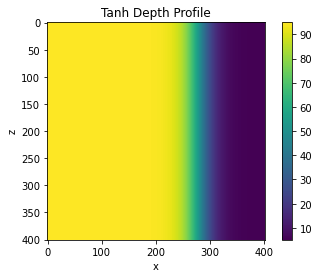

In [12]:
# NBVAL_IGNORE_OUTPUT
plotDepthProfile(h, "Tanh Depth Profile")

In [13]:
# NBVAL_IGNORE_OUTPUT

# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)

# Compile the operator
op = ForwardOperator(etasave, eta, M, N, h, D, g, alpha, grid)

# Use the operator
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

The nt/nsnaps factor is 20

Operator `Kernel` ran in 10.70 s

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=10.634207999999974, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.06243400000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [14]:
# NBVAL_SKIP
snaps2video(etasave, "Modeling a tsunami in an ocean with 1D Tanh depth variation")

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQABEpdtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz05IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAHDlliIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAACv1n8XZ0rMAV8GBpq6Gg8MrEeljCFhP/fBy0VEckbD4emv
5HACvp4XDeD5O6CTNWQDCaRPf+W2anRytXdO24NF6KpQpBA6sdoG1taj25ErXdc/Ka8y5DuutDro
2BQI0hvs1hK5TpWVS/LnOYos+DFj+xx/Oly9yWFBR2K91Me9nKQR4opRpHHp70A05iAF+K3Ef7C3
zgRaiYN1Dq0+X4bKDAG9DX9ZLROvUz31UmUCm9ndhJVyf9XWvmc2XREHh8C2kvEyKknuD3UIxLaS
YiH7MM50dxYNZohJlc42YROt9qH4ARGM2F2OfJajc2yjL4hIQ0jFVVB5hmuXdJEkuFQGDhKx81V6
e/p+J0pMQnvlDN8QzTIHihB43fFKPOHIGizERGf1lUJk3IHiRX4/7TMYXg3Fq2d87HR/l9w/gv9G
Bo5xJsQczy1OgHNWlp7bEeLpNk5U5W6xm1Ue6qwT//zWrV6ErzWuy84DMoW2EemglV4UirnRbbG/
4CnxdXOSBHvrQFTJQuyyzP3Tp5vTxxWotMwqvzGossikFP06PGnSYz60TpSONp9N7ljPSriyWQP8
bX9aHluG3W1Lc+Jj5QeiW18MSbdQYn0Fr3ZSVDpWJGT7gazh9xclY7OdceApDRhJ3/8MTAaPtqri
oeWN4deJXouQ/9er9HeRPtAvx0rr3W/w95tKPV8aE+MxuBiN1+jt3gLJB2jyfPPRfjWrK5gCf6Za
0DNyoz3gkFgDCLYTeFkz/rKc5eWJQGwOZErgZ6oFWnDP5mtztRFHbCle3883iajUuc+IAJbaTxkh
wNKQ8IQFosUmx70g6mjhM7UdOMJ5QDSs/u09EI94vJRIL5GZobrxdyPiH0n6bvqI9oMjFmP9T6gb
/1ifUebEyGK2wrl2ps5k8WejUr+ocda6I0TprHVNtgPG8x4/0QHMsCJNcz2DBDRfKl/aoWdI8Pps
gRMToC602uX4D3I/oXz3XvCgjea1a44HkvoiZB9JH+OR45e1yLv08F4yhQjRniXDGqPBMJ58+RXd
f9gyyvazCWSc5AMH/fmFckRTOGfyRaUanGHxY1G7cSakl6RPI/H/0Auu35cHU1oTXI5dYy08w1L8
vZP/kAeiF7ZOhV5htBvBlrYACOwZ2gHQEKpHQECVjzfi4d1wGpW21Kz7IwAYz9Y6KPkaQ/T/Evpw
E3DiqKzUbMe32vaHmbL+d31EOZQkryzB/6j0S7EWQ/kJQsV7v+K6rq1PwgLqlI0LJAFKTVFTBuNH
m7j8suygT2Zq+x+hwhrVFYWRYHV4oTu5ht7etvPcgKN155UtPTFMayBE2ZpeN+MXd/MS7bMBYDMU
elmhfbXqysKjhbv21IWaaf+22RUS9wBCnfrss7Ueax8jLt/VSM37wzR2Tzc/KYtwYA9d7WJuEUjx
EpcofWmGQ4AKFmdbiYamOMtZnl5Jl8b8XNXp1P2/al9qA+wUMyKS6p2Iyv2UneUlpBW0s28yO8vZ
P/ceeAR3VM/PkT+gMeQsRIZqgYrij6i2lEzPJXjCBtK+5PIRpqRn3GL4UwOACwflBMsUGocCxjh1
DVTOEY956NXZ3Qm5xV9Vfg5m4TUdbRWkCnPtQokCvtHWhqR2cfzixjfzGgLV6meviut8UY7mPuSt
BMXR8ayAKPvMyyS/cInO7oXOCWgK0JSqrCBAidjwyouTgFDCD4GB4YfQTiZkojfqETdshOv8r+0h
OEqnzN0ykcfXuIu8S8jKPlJJYTpuvvn/1lT58fLoPpsLaf/rki/7VISx2zhUqPJVIvdBX0gSobQN
WB0/1NQApH9/Znz7GP5oK+00gyvmqF0Cl9mkVDR3d8V7K1AMNRydLprtw6CppOc8pXsHuMLF4X1U
O7Xllq0WsL6tdfFhSaAZSWN8autSlYD1DcL+7gSIW5HA1qcmrkE7sPUdmCQf6l7DmVPuy4LBN4JA
aDvK8GsGwhVTbEA/ILWCkUp4Gy/PnKxgmdKOmgt8uWtL9UyYF16JITolXI5xnrgYmPqs1aFnQhnN
3bzJNnZGEzSwJKtHjHfVEyWi0lwYkLJI5KGQk/Wr1xyHxXez4hvY/jBaHtGYr3vFeK0kr7LTUm77
vRbQ7hRApkgCMuFN4ge9dCxqFyV+zyrZut8BLUekNYNfdmbgO8QBQ86OpjlUAryB6JgSbO2IIhwZ
NSHAzxopMOoVGj2QPymeLNDV/byg0/XXv0dxszRDOtthXOyiOtN4QRhCc8kEG5/tgL04XZYtTxd5
vgKCvm/ZarqldlN32U0xbeJ55zTNVyTsN0Wfu0NhDUvvwE6uaoZcKMfRokbXDDlvY9vZSchfWmiB
UQI4OqOIth8CDeyz/mElLNufZaE+sAi4fOQsYyG7jD+qYJtYx1JUVV5L7fKJIgAJbdD9Hr++HLNb
xhRglTBUN/tUq+aYnPdKp4M87LjrXcpZZEbmGTeg3wxAaJataUCSNQyXPi0EWuN+Dic6dIqOTvP5
1SdMRAx/rAa/FRnzgI6fTyCaHA7Vhnqvc/IADtxzQ5oxY/F5KVlcwi7CxV4WVIJ6lKzWiBh+YfkX
Ee+SPDMObRbheSXuiDhIxhLhj4P0LriP8J9SyIPyt0a4Zt+EMLL2X50wlGkGTqt+AqUJZtdyj/Qj
xIzOJCTpTysl3k0DhPEQJue0Csdic6iRmn39daCZmEUMxwBPoYfQ28bcceyW4hTwdkqW2Q5fE+U/
C6MN5iCgX6Hf6iAYA1CdsrwXYo9yBIi73xPZONJtnYnYTfbugpj4fN53KDlJUS5fKehT3VBbVKTs
4EAPgtBzy+N0bnA6jVutZWegJiJNTPV6WuW6r2igKC5JUi2PVnMy2FwhWp26estMCAdS8itngKTQ
OPZ3qY8zTjAkoAI0OKG7p

## Example IV: Tsunami in an ocean with a seamount

What happens if we have a constant bathymetry, except for a small
seamount reaching 5 m below the water surface? Lets define the model
parameters:

In [15]:
# Define constant ocean depth profile h = 50 m
h0 = 50. * np.ones_like(X)

# Adding seamount to seafloor topography
h0 -= 45. * np.exp(-((X-50)**2/20)-((Y-50)**2/20))

# Define initial eta [m]
eta0 = 0.5 * np.exp(-((X-30)**2/5)-((Y-50)**2/5))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 2.
dt = 1/8000.
nt = (int)(Tmax/dt)

Let’s take a look into how this depth profile $h$ looks in the plot
below.

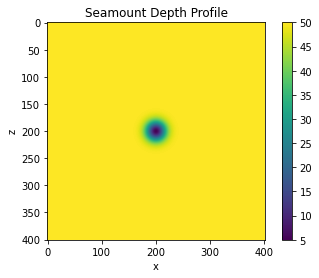

In [16]:
# NBVAL_IGNORE_OUTPUT
plotDepthProfile(h, "Seamount Depth Profile")

In [17]:
# NBVAL_IGNORE_OUTPUT

# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)

# Compile the operator
op = ForwardOperator(etasave, eta, M, N, h, D, g, alpha, grid)

# Use the operator
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

The nt/nsnaps factor is 40

Operator `Kernel` ran in 21.54 s

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=21.467746999999985, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.06220900000000002, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [18]:
# NBVAL_SKIP
snaps2video(etasave, "Modeling a tsunami in an ocean with a seamount")

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA/kxtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz05IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAGo5liIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAACurHPsRPNnqbElqAErX14M9rch2wv223VNYLTNC0fwxzx/
u/29jz6tfQbFkM2SEBE44cm9Y086xF4IJ6I30xfB/1R3xo/0gY6oNLSQjDRTuoQz2zUAbm+VlY+b
R7BJF+s89k9Dues4P4Yvy9FCe2nH+m0CzevZCSkQ3zu6SAxhKG/cgBI2QYnak9VEW51aOTILh5Y3
k0kEDAdku5WY/zoks0h6BU6wT3qxkGv50Gx+Qzc+9jPQFGFcMghfMQ8JXa8NjCbjvP/QpJG+gp+B
ukzbQCXF7e2TZ/bjPE8NSJ06B/6pC5fGqPS8SQfJrhlm7clNJng91AoON1WUAXo21/Ox3v6RkXrw
uS19G9QX17N75cESAwQHmD8dEX8owD/tBrDXDX4rQOz+AxJycLDNQMvXeARRswrPGcbJNJ5ixtw2
x/K75J6c/2X9UEySzhecDqshl8XPCOtaknYmpyjm8eB05Y2/tDhaNvhXCFGweBC9K8V2n6vYa48A
Ha367VHUctQKOnMUmJ8/Kjil2/A+P/vVKe+fKiDheozlD1+SP5zXahhRKYhpZGqQSpZlaUqHwTje
H435dKZkdkbrnglFJqj+sd/UhzHY/vwdzVSzrYALzUGzLneg0/gXj5HR7mctr7CdaF9GlQj4HkyT
yNs8BVDTqBgNfql556RxDEf9HhH+Gkb7i+zEfyaBBtKRQaFQ8672ycgfWd5b2918w3CrkwmPK1jv
lCturzDO6UJig919vekYSN+Oj5/Noo26L6Gkt/lIYOyVgdIFUaqdufKqwAiJV0MPsEZtzYlHNJbT
itde9RDwQDBl9Fjzj9vqM94Hf9qNXHrlvh6qeUsej4z447rg7SCuiQEpDHZrci74YoQE6aEbovHq
QzQaJZSk56tLPiX1qKkCgHb+9/bVFZRGS8qRC42lw37iwAWCPBf2ubxrXZnwrvSTZtoezAHq5zyI
eNn398Gzbiv4Fv5cc13lXqH/eWcoLf2GvgtuVinhQWPw/D74dM9N1vE7U4mA6qCx9rMlrym2+thh
0h94gSi0NpMEtXgOJ6hFoTb2bGySZXaPhgOWLFxnc/DLkxrl5eUru6rw+AALlQSVbOwmUGEByHCS
LYVHogeFK74GkJcLo2d5NPYPFJEYAUM1BydwXNkzHpJv2CXyBy3Q/XCJSD7gjQmHjHiUTJTO7LSk
fbheRftzwpmeMAZsPn/QswKRVC4c5J2DuDjX5b0tzL+iBM3iX4PLdparF3ewoZozeH89uTV7ro6Q
T+j56DPWbpL3AV5Mo00yo1aUBoMbJ8la7bHHrl0IvGNAOw485XECBMNU2TNnp3zYzaQUgGALx7qs
UJsj+z10sz4KhCSvARuZZClBQs4i89ytxmEjYGAnOiiEw4UbQ61tDZK+UV3ftI7kJFaVgKLN7pvV
jlzbTZZqehIrwLlgT27zjGp80iHUiEEDsemN7LB+YAJoR44mMxCPbV9xh9kU7Ou9gjwT1cXDCCiy
mztd331od3JeplJv2z905VpGMKIogoyV1OlzBeH8TnD3Npw2tPYlKjs/yb7qT4wMVrTZiuQNU/lk
Q6LquZI3oZaVH+wozDZ3ylheHR0VljnPs7v6taZ9FHR29OhUGI/X4+OEQwwwhCCXbqLqc28OcY3e
TXOp/cikdMy1dyln2gvU1Uj4Rclh5FOfczjLmqi+y2Tk9RwtmMs1iGnqQbwJFTli6HzBkvdAkB2x
VTstko1uRHHfZHbB8lO1aziw/KsgGQ63bU/1KiVGLb/MQ5c0jxCQFkVXq0NSOAIK2LTkPy+z59Rr
08aWwRlfzIloijXUSslBg4yxoad7dQAj57OBX/iF1gM9f+Y/8xfVHXHIzC5Mlhi18mg4BhHDtPcW
sYzOnb1u6ul5lOj/8kijyRy4Gto8s5K0yXPYfRx24ASkboq5u1z4Jd2PSSnBeifqxX1P4C1aavvr
EMYocDsh+33l2WPkAydti9rTqhIc8QlAKXjcklciU8wJYhx5Rf1UTQjvaICU6A8K3DzlZvdNJrg4
OYMQuw5//AaWOaYkNdhjlOiH8fD/1nKJddznOR8ENAlz7TNan0OsgW8sAD8FdG7fULeUVozuwyaG
uPTZqXqd01b/Rz6k+WpusCNIrQ4N8+dKRQGq/snx/yxNyBUd0N6FaG3fZ+RlC0UuJze6USsxmcPa
QUuJ3wH11GLJX5irNqnkXB7R3lFMPpHJhDYvlqNj6jB4R5USz5RCzdSy74EHfysXO6AfBjq7NysV
zAYBMvk0I4ubaTz0PARslHT2c21W/oF90pryGcCJP/Gb3iL/Oft8l+jPyqveD1culzZUUBp7Q4Y+
/tku5wDq2VyG8zLF4CsV6P+1J5TTBxxcRw+WfOex2UDJGTdySRkpiI8vZ22n9uRBP+QGR8h48DUm
BjPQ5OChFRCje8v6zgNUeGeY080EDcBfF2ca0sckdGU9HTYRmH/y4OWlB7/coS20izirhIyWbIWc
RIkT619s6hSvbg0LPU+9HIJo1yMkVUxHOrMoRpkEbs5eFDhcKsmtO8Wkl2znqlYKc3LsM8FY6E1L
0glCfMsTNBeHPT4VWHmA229a/LAz9pnZ1ZtIR/Fh859bJ4n1pA96C10AFTItd9cNPUl8fwNRIN6Q
TEaItd/p9vbWiyjMFXGPK+i42WNZz0I9BZvWMvfVWsQfcP/YTVUNrM3STguYn6pp0qT8/XULXuCP
PWKEpn55vqHnPSi80OzJ3hllG4h4Ysw6f36h1NM2zP9rIWzhL4ngHMJXioGIxl8eeRYz5IskRz/0
RWlVaDIO4pPozBAIGcnaoXsYY4/nt8FSGnwHqv33AqpAeABElpAvnbEXnOoqFuTN1bdm7b+GJgvZ
9nMMqg65oG6HsgXc32uvx

## Example V: Tsunami in an ocean with random seafloor topography variations

Another modelling idea: what is the influence of the roughness of the
seafloor topography. First, we add some random perturbations on the
constant bathymetry model $h_0$ by using the `random.rand` function from
the `NumPy` library. To smooth the random perturbations, we apply the
`gaussian_filter` from the `SciPy`library:

In [19]:
from scipy.ndimage import gaussian_filter

# Define constant ocean depth profile h = 30 m
h0 = 30. * np.ones_like(X)

# Add random seafloor perturbation of +- 5m
pert = 5.   # perturbation amplitude

np.random.seed(102034)
r = 2.0 * (np.random.rand(ny, nx) - 0.5) * pert # create random number perturbations
r = gaussian_filter(r, sigma=16) # smooth random number perturbation
h0 = h0 * (1 + r) # add perturbations to constant seafloor

# Define initial eta [m]
eta0 = 0.2 * np.exp(-((X-30)**2/5)-((Y-50)**2/5))

# Define initial M and N
M0 = 100. * eta0
N0 = 0. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 3.
dt = 1/4000.
nt = (int)(Tmax/dt)

Let’s take a look into how this depth profile $h$ looks in the plot
below.

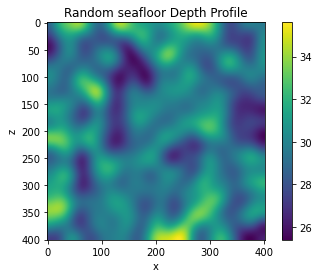

In [20]:
# NBVAL_IGNORE_OUTPUT
plotDepthProfile(h, "Random seafloor Depth Profile")

In [21]:
# NBVAL_IGNORE_OUTPUT

# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)


# Compile the operator again
op = ForwardOperator(etasave, eta, M, N, h, D, g, alpha, grid)

# Use the operator
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

The nt/nsnaps factor is 30

Operator `Kernel` ran in 16.40 s

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=16.326802999999938, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.06265700000000003, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [22]:
# NBVAL_SKIP
snaps2video(etasave, "Modeling a tsunami in an ocean with random seafloor topography variations")

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA5E1tZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz05IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAHTJliIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAAGGTCPj8jbqAFpKU/+yAlXnx1LhKqmf4e+0Mprjpdv1euBl
/6q8GUaPa/QN09U3poij1zbzjugVwuVeGaWxmIpj5zrllF9jeSrxsqzbG3y5OfaAxSR4tIrcYdi+
H5pZBUoiE00Lr1G1URC9CXBxbU/5+btjflQWmKwf95Q7vlaZ81hpKXSy4gZBNB/s2C60XeJFOO9R
AWJK1ymlRZ0WeHdHIVigMn02RGisF/tRIcIrtWwqg+7h92H0SgZFt+LtjIPouis4U2kd338F7J/B
LkGaErK+Xx0jtzt4fuax7I1oNMIwvhvbILgTw2aqg1mjUcZybeB5jY3hLka36BF06zbFgpmW3UfD
AlXff4w2QOdQnz0cCJLmMan/O7wmEfjZvnViwB1KaaZEfhHg4dyfz/cDDU9nJ4OMoTVwxxKBSom2
XKob6zx650/upcv3fLE//MzEpHEo29NoBywCcxuJNRAEfHlRRQsemJycQaarZtpmSW0tYaL/CfWZ
fjyagmad2S3NHBcJAoWyyooQYz0mqUIhBSOCbNKNfWpa0bGgBIRslV6k7dBJu0yuNU2w0Xzw/rjN
d5/mbZph9W0Jf8jxUv+ts7w+UU3e5KGQxxwQtRfjT+jbOaLVHHxl+FJrogYGVHG94jj/dN5fvuDj
leF/EgBOHdtXzvUJV8Zrr7soGjSub7kljXLb2Py9l3wZuaXsspFrnvFmW0BkfsQeXKrN5Fo/fDc/
zg1d4XeHOHG2OmSrmlInI44lg/zpWH47n9iZc0gcxypTFsKWIQ1BcPGFxSHruimHNR76+5T+c0cE
1w9hgYGZ+7KPWfXp5c6KqHNKZ86uKX1OoKCJCVhDkDJP3mSudC664kbLzq3e6UZ8cZsnj6inQKpx
YNjriC3g4X7cydZ7+vGM7aLo922va6CyF7KqcqtRtCk/F1v5SnxffCjwYWlDNBEpwYXQ80gy2vDX
btLFgjJmuzRecL971g+FqlO6O8qCWmgjsja7zy6p15VqrAzZOGkKdbMcxnnrdko6qSY/ZlTn7p0v
45Riiq6iU6V08cPAYMlCpMONnSWkpSH9/GoahyTlF6IGLiXGS1Bj+ASI5r809oSJ8/loHv6Dt+3u
JcqFx7s+mEo47cXd8UbEGXyahnIEth56la+WKCl4WjMpoFxH3IrW+3hxnl6r6w+LD5yikEe7RB3g
cBvXWNcPV+WLsm8Go4CZLy5MK8gXy5AxP978IcbW2gD1ku7FaAXMjNEjMeQJOR+18KL4RSGPXzej
X7sStBjNm68+7USALqZKMFLau1LumDEBaQiRCr6ot16AfyMMTPnCR/8pRJRRPmB38BNbWUAb0p1A
GgEVcVm8Cx8sQNv9n4giRbzHQ2+B5G7ns6HdOUC59o60NaCHCEFu3OHBQ6uoQvxJxq/XLRNStNcT
6yHTp+JZcOG501McStmMcFTErulwghvgbKgD5olWztEf4Siwref5aUaMi+EkOLteopU6YcCkvy34
mXe4jKg4MSFpCBgfGp2VIYSv5yJQd0FtFnuaX3QotABxElmSVhQep+7RMC991gy6rTm6tdV+IBYx
KfIni2ca5ERrb1YgE+6RHl2yeuK22kGe60TEPxxjuZTx8JxcHcNH7rhh1IZmD2OVFXqTBSdh/Z1r
CZ+ojRhNhUJkj8HHM1cU7HakeQngxq3ZQ48nuC9NUe2fMnCPo/FsuXHjeUry4biYa6VECZjfII3J
QMsudIHC0FaJTvXeTaSjbBgQkuVepLZH1j/aqsJn6odyOiOMWic2gYbU/JeRGsJxFMqOTbygfQiq
kXGWq+uTdqlaaQcloot22nsEAs3WPypB/m/RYdsDikzbM8pf8BMXHHyKNjgVNLqqB7jWUFg6Hrp8
qFmdwH4Ti48cvbvVPxq3v1awwuVVFs1Ba/Buzx+rNF6S8x/1EsnsixiPiu3XjxIZFxNng+jIc3Pn
4aJGeZnnyL6HjTWerD8zfUKQCdDbAgRI2RnFa0S+DPlew8ySinwju9YkD0sq0einaQ2/eijce96b
WzRsMxz5Uj7vf8rvFYVgakgbrsLQsdVQbalYY9rCYU6VEcRWImnbTAYN5FonKBQX5yyom5cdOauy
7RGtyZ0lNRHVgQSSvFRbR7GOgiMp7aAZf9uncKiXg78RTomCn0/xTGcyV8aXANc2tMqZQMmLOtNt
7Qm4LC9m61qWn1eVWf5TRhisWq3tQBhLiMjwUZbwl6FNqU0ADhRM+IZYQD/eAmGIzeOwte1eZzsC
k7IIVboOd5BXgR2Sojh1afVcbQt6CtjWhsmzrGBjyv7Mm7fQM6Gx+mRoZnZM1h55oWVTa8VuCU6L
YAWc/qaxA8ASl1tCGIJII8Th5IaoaxUwcqV+yk4ZmEdNQKXLAoQpQI8zVQhjFV5wKUpMQCass385
WKLp0slzGmnv670zbqMZsbwe7hz10ZVgaLRDDQq252jlQ9qsCioT0iFKc8hKFCqTfziB2b9WrMmG
4zwsBhLUaUnEHb8Vsp9Uhj5+MOVCcLf+gtHaWu7jN8s6J17tyyf6Ocsf+gVVHjDIqaw/HGRwC7l6
P+y2ZgCSN32z7zygcxXOvwf/Z4ZX4/IaefDe2VdF4DQLkLC8fyrIlY+1+AOnRF5i3NOUwiYmagBQ
mVwvT6yX1B99EYFKg/6LwAi755JsAzXFTbaZqodJ32O+G+yw69uZncGBzJxQwz0LsKxYA8XD5vtJ
dNnLRjHIhL9shyeN6BxYi4gh/P2LCH3jQpnbtxznE9TYORHuxXJCwK8S1FwwlwbHcKwd5rtd6ola
SA6A+V9oSjGH2qAP6GmiPrTCOJqInIkl17tLshOT+CGzUq0gLo0soxhKPBaptnE/BY+f/CSjff/9
fBH0NzDEbMArMYZbUxp4y

## Example VI: 2D circular dam break problem

As a final modelling example, let’s take a look at an (academic)
engineering problem: a tsunami induced by the collapse of a circular dam
in a lake with a constant bathymetry of 30 m. We only need to set the
wave height in a circle with radius $r_0 = 5\; m$ to $\eta_0 = 0.5 \; m$
and to zero everywhere else. To avoid the occurence of high frequency
artifacts in the wavefield, known as numerical grid dispersion, we apply
a Gaussian filter to the initial wave height. To achieve a symmetric dam
collapse, the initial discharge fluxes $M_0,N_0$ are set to equal
values.

In [23]:
# Define constant ocean depth profile h = 30 m
h0 = 30. * np.ones_like(X)

# Define initial eta [m]
eta0 = np.zeros_like(X)

# Define mask for circular dam location with radius r0
r0 = 5.
mask = np.where(np.sqrt((X-50)**2 + (Y-50)**2) <= r0)

# Set wave height in dam to 0.5 m
eta0[mask] = 0.5

# Smooth dam boundaries with gaussian filter
eta0 = gaussian_filter(eta0, sigma=8) # smooth random number perturbation

# Define initial M and N
M0 = 1. * eta0
N0 = 1. * M0
D0 = eta0 + h0

# Maximum wave propagation time [s]
Tmax = 3.
dt = 1/4000.
nt = (int)(Tmax/dt)

In [24]:
# NBVAL_IGNORE_OUTPUT

# Inserting initial conditions
eta.data[0] = eta0.copy()
M.data[0]   = M0.copy()
N.data[0]   = N0.copy()
D.data[:]   = eta0 + h0
h.data[:]   = h0.copy()

# Setting up function to save the snapshots
factor = round(nt / nsnaps)
print(f"The nt/nsnaps factor is {factor}")
time_subsampled = ConditionalDimension('t_sub', parent=grid.time_dim, factor=factor)
etasave = TimeFunction(name='etasave', grid=grid, space_order=2,
                       save=nsnaps, time_dim=time_subsampled)

# Compile the operator again
op = ForwardOperator(etasave, eta, M, N, h, D, g, alpha, grid)

# Use the operator
op(eta=eta, etasave=etasave, M=M, N=N, D=D, h=h, time=nt-2, dt=dt)

The nt/nsnaps factor is 30

Operator `Kernel` ran in 16.72 s

PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=16.65377599999995, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.06264100000000003, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

In [25]:
# NBVAL_SKIP
snaps2video(etasave, "Modeling a 2D circular dam break problem")

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAA+qVtZGF0AAACoAYF//+c
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MyAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjEgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz05IGxvb2thaGVhZF90aHJl
YWRzPTEgc2xpY2VkX3RocmVhZHM9MCBucj0wIGRlY2ltYXRlPTEgaW50ZXJsYWNlZD0wIGJsdXJh
eV9jb21wYXQ9MCBjb25zdHJhaW5lZF9pbnRyYT0wIGJmcmFtZXM9MyBiX3B5cmFtaWQ9MiBiX2Fk
YXB0PTEgYl9iaWFzPTAgZGlyZWN0PTEgd2VpZ2h0Yj0xIG9wZW5fZ29wPTAgd2VpZ2h0cD0yIGtl
eWludD0yNTAga2V5aW50X21pbj0yMCBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9v
a2FoZWFkPTQwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjMuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBt
YXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAAGjpliIQAP//+92ifApta
Q3qA5JXFJdtPgf+rZ3B8j+kDAAADAACurHPouCfhBiEBZmAHFjI6y7XTWOBxhtSaHayefNJyzIsR
QNTPs4iKjQ6FbkBHRTeT7T/eHLg4/0EqoU9aDwMVM3UeXxZ/C6apSlvXXcfJiIj3C1ldHnrUzKb1
kbbOgev7yLxKZ0XMzYHVOBk0dNsyCv7jCMJacrtfWj6Tx3gsYpNdIqr7RUFy7TdaN6Yhnqeg79ba
TMVdkTc5RKve8U65oTYLIvvsqbrq4w6k9q+L0vyoRbuwYrYRNbOWQmOWJzTxLXBKnKUn45LjKzwL
4lNqRW8VB7CV1LIKMWBxgGez/Rv2QMklWYwuHHvA4JcNuNQ4cid/fGI2lg0ECeGhJXYYdTSgcSaF
WDEuYY/tSytzNrKgxSQbQn3gPVgoCDzgKC3xRWpAknmqt/9swrjHIm4ho3SvxNj2XebrRxhXfDQX
Bs+PVlsn0zkxj054DyCEUpTIcKJuP2yvoKRrVybvFzzb3WwhglN8+8BpmuYOKaSNHdhSFH53p4Qk
NXU4dGTLMxVphS9ifgvb3wxhPDydQcX3c6In0e04LSPa0EqffK0VLMaXic1ZkrQEkr6qYXQGNOUU
QRT+t4hMjDP4jgj9JiB4nF2GRdY6G4tABikU59syIaK3o9TqkkYXWZagia5+xxv4s+zRRiyAW8Ct
QiwTXpsaSOWlH2SVgA/2D8cwp4MEmyOsJyiciI32uckHmzEB5gGintaDFQ+SaL3ML3aO2Vlm2e+O
1/sw432iGyHqZZ1MRV7X6NBaDn+YeruHZ9lOCVVfT9Eoy7AzVHZNSLU45Qn5Kj6IxIFqlIJEMmJY
bx6lFQ7AwXNSJWmpBxu91r6l5vpL2sPYxfMYhsGbt40ggxCcf5deLuD/woeA5ugpHxaRSiMCe/9M
RkmUj26M3BPvKMu5ukCpBZOFNTi7cjdpGtMuhT9ni+0Gia8cLXwX3SQ91ddSBfhgVl7RpqKJajb+
IX4DE6fNVYW01zI8kram9e8uzarx5u7m6TGAq8jLKPJ0zSquZKMyiHEVGCA0gci93Sb5ePPLzH1Y
DMg2Veu4hPOjfJYzFUqZBJD9eNMa8DSnio0jRUcYg7wIP/C8eyruM8j28firdDhdRH+gsN1KK1kd
qApk5YMRtg/C7ByLUxLJA7KPL4h1dcw8Qfcolf0XiI1/x/F8LIyA3ehr47eSCFVf4Krge7Snv4hx
9TPaVXpWPb/8YXbuA4gA6QqEM2oaNqO8gvD7bABn57ZCA12NvfuO+4H/boUid6Yrp9K9OyLO/ml5
wHoSn6iYO6l9dLS5CBs2h2JpEcxgOqkrgoHFjvxrUF2gcU5qwMX1nE/AMeeEUjEhfCntm88hvqnf
PROyEVH5oqD7TqF9LSSliX3UrR9IqH9ICpBTIwPunJyrP4SZOYf4kTbhRj+kG5DNkK0QMoAcmT48
JC5IZ6tAf86LPoil4jin0Q6YqUMQE+CqcqvkrgmwMPOBErRqUhabmTR2WNIS1f+Kdfq9w00Pgfri
nNdfVpu5m8lgQFMqzHgPlHY1jAvOq9kTsufawrZPMWgMHEiyo6Ub+FhEg2bN5EOe+rvDjrGszvii
Aa6j8gEnCER+AgFR1a7clmRyl83N0LZeQubwPYWbFYz6iSePgnY0cataRVmYkVMOWq1+yk5JjJGT
zZ/+WyldHjfC0dttityfiXJ5jLjayP07HenIbP2DhGABVinSbTRWiThAUeC21x6LOBXoyFcaL8bX
xP6Bl8//gW5of7m2bNri5fQY4n7dU5i24hzx4vr+6FZ1QG0aLADfPwf/nzF6ktyeU9kSlRB2WUhG
h1PWaOL/q0h7NTCGRDDA+Ni887PP2kkvkYE2iVCuOtBfj9gC2ch98Gjn0QnHwRo795zzsIsnTw5Z
2D9j8upJ2U9OH04yAfbX3H4IzU3e0RKDA4eVVWT44rpzvYCUPf/dRy7iouXwxlRizvFLmPGzKqff
X5+ru441/6h8zSSEPhtudlUKo91YYiMdfp7ZQs2shThDfqPdG0x+gfI4tf7LkawV43L9aRePPh8s
9njcuNT3Cz199MyWliv6uA2Vh/rsSjLIWCaMGH8oA4MSvCAeGq1TNzfXyHVTtaQViGsc7rKu18Et
Vxy2k1kOJ8ibvnjLaej+9/2+DPhr71duEDMqZqtj27wGYllN0bD58zgYJ80jnVUH/XHcSNqhvu2Y
y/lIGX2XM14ojax4kglg/QPQn2LYuOlXz4Xi7cyW5IioKSNOcKbEpm9RHueEdYJft/1tk5LMKACP
0n699hMLbNnUrDdP6WVbIDNUxdMmt3IM5hdQv/lL0hDOoUtGWPCFezao1XdlRx9j22kO+RV05e0v
LqfdM2CSQjoe+7MguYd0S6NcbpTF1zbg8oioIEuPgRbG4/rdmBeTjFp9jRc+CkNPyUtqF6fG/2HH
rGPB7DKQSNlaQQuL0V8Q3OzdaAAcZ8NONnYyZ3Ouq+lJ8XZgub+RTJS01TCoGf4yFRYsXZZwZxDw
xZh0/v1DqaZtmf7WQtnCXxO7GKctQ5l4nZUyI5p9HXbZf3oKTxYsjt39ok3McN5m2Ya0naoXtE29
HSSg6Us1uP7osdSqVCrLTXbXq+Yk5jTZsUuFhqnRKP7LZKiZfcvVqPmnzy4LjYmzBmFPd2Bfj1D4
hnsqkWLyLKcmggBGAuHvHsCPkgWeAib1QvvaP4Rib7JW0bofO64XSxHRJXSdV4UsyTNtLZ8mrjBK
KfP4nPv3XxRJV1khJjdeLa9+4wTygdOzJZTN2hi16BSEcv9pzr5z7IN8ep19TkFIHM9VFJyFeSB2
O9WgZkY72ZjQ5Fr6lnc0/TXAAAEp9hYSyU9w6G1xtieVRMaRLGsdtjmcj8J3l699Lf/628GLjIHi
13sJNjahvH/GWhuWroCzJ

## What we learned:

-   How to solve the 2D Shallow Water Equation using the FTCS finite
    difference scheme.

-   Propagation of (multiple) Tsunamis in an ocean with constant
    bathymetry.

-   Tsunamis reaching shallow waters near a coast will slow down, their
    wavelength decrease, while their wave height increases.

-   The influence of a seamount and roughness of the seafloor
    topoghraphy on the Tsunami wavefield.

-   Tsunami modelling for engineering problems, like the collapse of
    dams.